Author: Andrea Baldanza 

Contact: baldanzaandrea@gmail.com


Internship work, Porto University, department of Physics.

Technical report: "Reinforcement learning: from principles to Variational Quantum Circuits implementation"
Link https://drive.google.com/file/d/1r5iE4CW0Xfa5onOq9pJunXFbgkU9CjRh/view?usp=sharin


Supervisors: Duarte Magano and Ariel Guerreiro

2024, July

## CLASSICAL REINFORCEMENT LEARNING ##

## Import of libraries ##

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os.path
from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import os
from PIL import Image
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

2.3.1+cpu
0.18.1+cpu


## INITIALIZE VALUES ##

In [2]:

Nx=4  #Points on x coordinate

Ny=3  #Points on y coordinate



Positions_of_obstacles=np.array([[1,1]])



ALIVE_positions = np.array([[3,2]]) #array of position x,y of the good terminal state
DEATH_positions = np.array([[3,1]]) #array of position x,y of bad terminal state
Obstacles_positions = np.array([[1,1]]) #array of position x,y of obstacle state


max_epoch = 100 #for Bellmann equation
NMEANS=5 
r=-0.004
Gamma=0.99 #discount factor
gamma =Gamma
N_times=1000 #SARSA AND Q-LEARNING NUMBER OF EPISODES TO SIMULATE
num_episodes=30000 #SARSA AND Q-LEARNING NUMBER OF EPISODES TO SIMULATE
epsilon_0=0.6 #INITIAL EPSILON FOR SARSA AND Q-LEARNING
epsilon_decay_steps = 1 #Every how much EPISODES divide by 2 epsilon
max_step_epsilon_min = (num_episodes)*5/10  #step when epsilon becomes epsilon_min
epsilon_min_SARSA = 0.0#Final epsilon for SARSA
epsilon_min_Q =0.01#Final epsilon for Q-Learning
alpha_0=0.2 # Initial Learning Rate for SARSA and Q-LEARNING
Decay_rate_max_step=5000 #Every how much EPISODES divide by 2 alpha
alpha_min_SARSA = 0.01 #Final Learning Rate for SARSA
alpha_min_Q_LEARNING = 0.01 #Final Learning Rate for SARSA




for parameters of DEEP-Q-learning see the section "DEEP Q LEARNING" > "Training Loop", in the training loop cell

In [3]:
ALIVE_position=[Nx-1,Ny-1] #useless
DEATH_position=[Nx-1,Ny-2] #useless

# ENVIRONMENT #

MAP x,y -> index and the contrary

 $i=x + Lx \cdot y$

In [4]:
def position_to_index(s):
  x = s[0]
  y = s[1]
  index = x + Nx * y
  return index

def index_to_position(index):
  x = index % Nx
  y = int(index / Nx)
  return np.array([x,y])

TEST

In [5]:
print(position_to_index([2,1]))
print(index_to_position(6))

ALIVE_indexes = [position_to_index(element) for element in ALIVE_positions]
DEATH_indexes = [position_to_index(element) for element in DEATH_positions]
OBSTACLES_indexes = [position_to_index(element) for element in Obstacles_positions]

print("Alive indexes = ",ALIVE_indexes)
print("DEATH indexes = ",DEATH_indexes)
print("OBSTACLES indexes = ",OBSTACLES_indexes)

6
[2 1]
Alive indexes =  [11]
DEATH indexes =  [7]
OBSTACLES indexes =  [5]


Creating adiacent lists to speedup the simulations

Neight_dist[index,direction] = distance from the "index" position and the nearest neighbors along the direction "direction"

"direction": 0=up, 1=right, 2=down, 3=left. 
The distance is 0 if along that direction there is a wall or an obstacle (it will remain on the same position)

In [6]:
neigh_dist = np.zeros((Nx*Ny,4))
for index in range(Nx * Ny):
  neigh_dist[index,0] = Nx 
  if index + Nx >= Nx*Ny or (index + Nx in OBSTACLES_indexes):
    neigh_dist[index,0] = 0

  neigh_dist[index,1] = +1
  if (index + 1) % Nx == 0 or (index + 1 in OBSTACLES_indexes):
    neigh_dist[index,1] = 0

  neigh_dist[index,2] = -Nx
  if (index - Nx)<0  or (index - Nx in OBSTACLES_indexes):
    neigh_dist[index,2] = 0

  neigh_dist[index,3] = -1
  if (index)%Nx==0 or (index - 1 in OBSTACLES_indexes):
    neigh_dist[index,3] = 0

  if (index in OBSTACLES_indexes) or (index in ALIVE_indexes) or (index in DEATH_indexes):
    for neigh in range(0,4):
      neigh_dist[index,neigh] = 0


print(neigh_dist)

[[ 4.  1.  0.  0.]
 [ 0.  1.  0. -1.]
 [ 4.  1.  0. -1.]
 [ 4.  0.  0. -1.]
 [ 4.  0. -4.  0.]
 [ 0.  0.  0.  0.]
 [ 4.  1. -4.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  1. -4.  0.]
 [ 0.  1.  0. -1.]
 [ 0.  1. -4. -1.]
 [ 0.  0.  0.  0.]]


TRANSITION FUNCTIONS

In [7]:
def prob_action(action): #PROBABILITIES
  '''
  This function take an action in input,
  give in output 2 arrays:
  1) probability to go up(0),right (1), down(2), left(3) in an array  [P(0), P(1), P(2), P(3)]
  2) Indexes of action [MOST_probable, SECOND_MOST_PROBABLE, THIRD_MOST_PROBABLE]
  i.e. If you choose action 0 (go up), you will have as output [0.8, 0.1, 0.0, 0.1], [0,1,3] Because the most probable thing that our agent can do is
  to go up (0) with a probability 0.8, the second is go right with probability 0.1 and the third is go left(3) with probability 0.1.
  '''
  if action==0: #up
    output = [[0.8, 0.1 ,0.0, 0.1], [0,1,3]]
    return output


  if action==1: #right
    output = [[0.1, 0.8 ,0.1, 0.0], [1,0,2]]
    return output


  if action==2: #down
    output = [[0.0, 0.1 ,0.8, 0.1], [2,1,3]]
    return output


  if action==3: #left
    output = [[0.1, 0.0 ,0.1, 0.8], [3,0,2]]
    return output



In [8]:
print(prob_action(3)[0], prob_action(3)[1])
a,b = prob_action(3)
print(a,b)

[0.1, 0.0, 0.1, 0.8] [3, 0, 2]
[0.1, 0.0, 0.1, 0.8] [3, 0, 2]


In [10]:
def Next_position(initial,action, control=False): #This function works when the 2 less probable actions have same probability.
  '''
  This is the Transition function: Given an action and the initial position, return the arrival position based on the transition probability
  '''
  prob,action_indexes = prob_action(action)
  rnd = np.random.rand()
  if control:
    print(rnd)
  if rnd<prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[0]]


  if rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]]+prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[1]]

  if rnd>prob[action_indexes[0]] + prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[2]]
  if control:
    print(final,prob[action_indexes[0]],rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]]+prob[action_indexes[1]], prob[action_indexes[0]] + prob[action_indexes[1]])
  return int(final)


Reward array 

In [11]:
R=np.zeros(Nx*Ny)
for i in range(Nx*Ny):
  if (i in ALIVE_indexes):
    R[i] = +1.0
  elif (i in DEATH_indexes):
    R[i] = -1.0
  else: R[i] = r

  if (i in OBSTACLES_indexes):
    R[i] = 0.0

print(R)

[-0.004 -0.004 -0.004 -0.004 -0.004  0.    -0.004 -1.    -0.004 -0.004
 -0.004  1.   ]


## Function of plot policy

In [12]:

def plot_policy(policy, title ="my_policy", Alive_indexes = [11], Death_indexes = [7], Obstacles_indexes = [5], Nx = 4, Ny = 3):
    '''
    this function take a deterministic policy in input and return a plot
    The policy is an array:  policy[index_position] = action
    '''
    #set lim
    plt.figure(figsize = (6,5))
    plt.xlim(-0.5,+Nx- 0.5)
    plt.ylim(-0.5,Ny-0.5)
    plt.xticks([])
    plt.yticks([])

    #build the grid
    for i in range(0,Ny+1):
        plt.axhline(i-0.5,color = "gray")

    for i in range(0,Nx+1):
        plt.axvline(i-0.5,color = "gray")

    #plot obstacoles and winning / losing states
    for i in Obstacles_indexes:
        plt.plot(i%Nx , int(i/Nx), marker = "s", markersize = 60, color = "black")
    for i in Alive_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "*", markersize = 60, color = "green")
    for i in Death_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "o", markersize = 60, color = "red")

    for i in range(len(policy)):
        if (i not in Alive_indexes) and (i not in Death_indexes) and (i not in Obstacles_indexes):
            plt.text(i%Nx-0.4, int(i/Nx)-0.15, str(r))

            if policy[i] == 0: #up
                plt.arrow(i%Nx, int(i/Nx)-0.3, 0, +0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 1: #right
                plt.arrow(i%Nx-0.3, int(i/Nx), +0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 2: #down
                plt.arrow(i%Nx, int(i/Nx)+0.3, 0, -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy[i] == 3: #left
                plt.arrow(i%Nx+0.3, int(i/Nx), -0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up
    name_file = title + ".pdf"
    plt.title(title)
    plt.savefig("plot_policy.pdf")



'''
policy = np.ones(12)
policy[0] = 3

policy[1] = 1

policy[2] = 2
plot_policy(policy)
plt.show()
'''

'\npolicy = np.ones(12)\npolicy[0] = 3\n\npolicy[1] = 1\n\npolicy[2] = 2\nplot_policy(policy)\nplt.show()\n'

# BELLMAN, SARSA AND Q LEARNING #

## 1)solve the bellmann equation throught the Bellmann update ##


TRANSITION PROBABILITY TENSOR from prob_action and adiacent lists

In [13]:
def transition_probability(s_1,s_0,a, verbose=False): #s_0 and s_1 have indices, a has index of the action
  '''
  returns the Probability to go from s_0 to s_1 performing an action a
  '''
  output = 0.0
  action_probabilities, _ = prob_action(a) 
  if verbose:
    for j in range(0,4):
      print(s_1, s_0+int(neigh_dist[s_0,j]),s_0)
  if s_1 ==s_0 + int(neigh_dist[s_0,0]): 
    if verbose:
      print("Control 0")
    output += action_probabilities[0]

  if s_1 ==s_0 + int(neigh_dist[s_0,1]):
    if verbose:
      print("Control 1")
    output += action_probabilities[1]

  if s_1 ==s_0 + int(neigh_dist[s_0,2]):
    if verbose:
      print("Control 2")
    output += action_probabilities[2]

  if s_1 ==s_0 + int(neigh_dist[s_0,3]):
    if verbose:
      print("Control 3")
    output += action_probabilities[3]

  if (s_0 in ALIVE_indexes) or (s_0 in DEATH_indexes):
    output=0.0
  return output
'''
my_sum=0.0
for i_state in range(6,8):
  for action in range(0,4):
    my_sum=0.0
    for f_state in range(0,12):

      #print(i_state,f_state, action,transition_probability(f_state,i_state,action))
      my_sum+=transition_probability(f_state,i_state,action)
    #print(my_sum)
'''

'\nmy_sum=0.0\nfor i_state in range(6,8):\n  for action in range(0,4):\n    my_sum=0.0\n    for f_state in range(0,12):\n\n      #print(i_state,f_state, action,transition_probability(f_state,i_state,action))\n      my_sum+=transition_probability(f_state,i_state,action)\n    #print(my_sum)\n'

BELLMAN UPDATE: $U\leftarrow \max_{a}\sum_{s'}P(s'|s,a)( r(s') + \gamma  U_i(s'))$

In [14]:
U = np.zeros((12))
U_1 = np.zeros((12))
#U_1[11]=+1.0
#U_1[7] = -1.0


u_update = 0.0
array_to_find_max = np.zeros(4)
array_to_find_max2 = np.zeros(4)

U_time = np.zeros((max_epoch,12))

for epochs in range(max_epoch-1):
  U=U_1.copy()
  for state_i in range(12):

    array_to_find_max = np.zeros(4)
    for action in range(4):
      for state_f in range(12):
        array_to_find_max[action] += transition_probability(state_f,state_i,action) * (Gamma*U[state_f] + R[state_f])

    u_update = np.max(array_to_find_max)

    #if (state_i in OBSTACLES_indexes) or (state_i in ALIVE_indexes) or (state_i in DEATH_indexes):
    #  u_update=R[state_i]
    U_1[state_i] = u_update
    U_time[epochs+1,state_i] = u_update
U[11]=+1.0
U[7] = -1.0
print(U)


[ 0.91041407  0.89407473  0.87656402  0.75943401  0.92900212  0.
  0.86542432 -1.          0.94578246  0.96487221  0.98210544  1.        ]


Find the best policy $\pi^*(s) = \argmax_a (U(s')P(s'|s,a))$

In [15]:

policy=np.zeros(12)
for i in range(12):
    my_sum=np.array([0.0,0.0,0.0,0.0])
    for action in range(0,4):
        for j in range(12):
            my_sum[action]+=transition_probability(j,i,action)*U[j]
    print(i, my_sum)
    print(np.argmax(my_sum))
    policy[i]=np.argmax(my_sum)

0 [0.92365058 0.8992014  0.90878013 0.91227287]
0
1 [0.89395759 0.88006616 0.89395759 0.9071462 ]
3
2 [0.85769033 0.78174604 0.86660209 0.88945862]
3
3 [-0.6364002   0.58349061  0.77114701  0.67719462]
2
4 [0.94242639 0.92882135 0.91413168 0.92882135]
0
5 [0. 0. 0. 0.]
0
6 [ 0.77222679 -0.61413305  0.68779365  0.8782064 ]
3
7 [0. 0. 0. 0.]
0
8 [0.94769143 0.95937622 0.93426716 0.94410442]
1
9 [0.96468655 0.9786588  0.96468655 0.94960041]
1
10 [0.98217158 0.98475298 0.88882668 0.95665074]
1
11 [0. 0. 0. 0.]
0


In [16]:
print(policy)

[0. 3. 3. 2. 0. 0. 3. 0. 1. 1. 1. 0.]


In [17]:

def My_action(a):#convert the 0,1,2,3 to "up","right","down",left
    if a==0: #UP
        return "up"
    elif a==1: #RIGHT
        return "right"
    elif a==2:#down
        return "down"
    elif a==3: #LEFT
        return "left"

Plot the policy

[0.91041407 0.89407474 0.87656403 0.75943554 0.92900213 0.
 0.86542434 0.         0.94578246 0.96487221 0.98210545 0.        ]


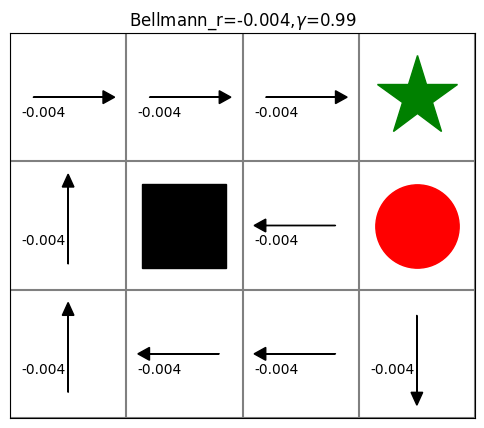

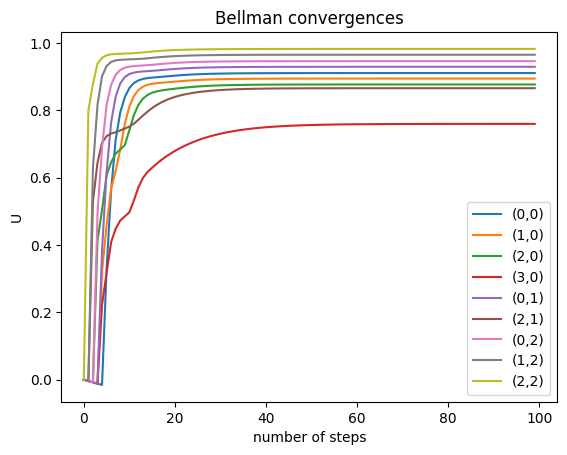

In [18]:

my_title = "Bellmann_r=" + f"{r:,}" + ",$\gamma$=" + f"{Gamma:,}"
plot_policy(policy, title = my_title)
plt.figure()
for j in range(12):
  if (j not in OBSTACLES_indexes) and (j not in ALIVE_indexes) and (j not in DEATH_indexes):
    position_str = "(" + str(j%Nx) + "," + str(int(j/Nx)) + ")"
    plt.plot(U_time[:,j], label =position_str)

U_final = U_time[max_epoch-1,:]
print(U_final)
plt.xlabel("number of steps")
plt.ylabel("U")
plt.title("Bellman convergences")
plt.savefig("Bellman convergences.pdf")
plt.legend()

## 2) SARSA AND Q-leaRning ##

### Some functions ###

In [20]:
def Next_position(initial,action, control=False): #(is the same of the one defined in Environment section, you can also toggle this)
  '''
  This is the Transition function: Given an action and the initial position, return the arrival position based on the transition probability
  '''
  prob,action_indexes = prob_action(action)
  rnd = np.random.rand()
  if control:
    print(rnd,prob[action_indexes[0]],neigh_dist[initial, action_indexes[0]],prob[action_indexes[0]], prob[action_indexes[0]] + prob[action_indexes[1]])
  if rnd<prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[0]]

  if rnd>prob[action_indexes[0]] and rnd<prob[action_indexes[0]] +prob[action_indexes[1]]:
    final = initial + neigh_dist[initial, action_indexes[1]]


  if rnd > prob[action_indexes[1]]+prob[action_indexes[0]]:
    final = initial + neigh_dist[initial, action_indexes[2]]


  return int(final)

print(Next_position(2,0,control = True))

def random_state(): #extract a random state
  output = int(np.random.rand()*12)
  while (output in OBSTACLES_indexes) or (output in ALIVE_indexes) or (output in DEATH_indexes):
    output = int(np.random.rand()*12)
  return output

0.058194060946480275 0.8 4.0 0.8 0.9
6


### 2.1)SARSA ###

In [21]:

Q = np.zeros((Nx * Ny, 4))
alpha = alpha_0
#NTIMES = 100
step =0
step_decay_rate =0
epsilon = epsilon_0
#SARSA
UTILITY3_SARSA = np.zeros(num_episodes)
UTILITY10_SARSA = np.zeros(num_episodes)
for i in range(num_episodes):
  state_t = random_state() #extract a random state
  #epsilon=1./(i+1)
  step+=1
  step_decay_rate +=1
  if epsilon > epsilon_min_SARSA:
    if step >= epsilon_decay_steps:
      step = 0
     # epsilon = epsilon/2.0
      epsilon = np.max([epsilon_0-(i/max_step_epsilon_min),0.0])
  #print(epsilon)
  if alpha>alpha_min_SARSA:
    if step_decay_rate >= Decay_rate_max_step:
      step_decay_rate = 0
      alpha = alpha/2.0
  #print(step, alpha,epsilon)

  for j in range(N_times):
    if np.random.rand()<epsilon:
      action_t = int(np.random.random() * 4)
    else:
      action_t = np.argmax(Q[state_t,:])

    state_t1 = Next_position(state_t,action_t)

    if np.random.rand()<epsilon:
      action_t1 = int(np.random.random() * 4)
    else:
      action_t1 = np.argmax(Q[state_t1,:])

    r_t1 = R[state_t1]
    Q[state_t,action_t] = Q[state_t,action_t] + alpha * (r_t1 + Gamma * Q[state_t1,action_t1] - Q[state_t,action_t])
    state_t = state_t1
    if (state_t1 in OBSTACLES_indexes) or (state_t1 in ALIVE_indexes) or (state_t1 in DEATH_indexes):
      break
  
  #I save utility of the state 3 and 10, useful for data analysis (The state 3 is the one hardest to reach, the state 10 is the one near the good terminal state and so most probable to reach)
  UTILITY3_SARSA[i] = np.max(Q[3,:]) 
  UTILITY10_SARSA[i] = np.max(Q[10,:])




PLOT Of policy SARSA and see residual respect to the Bellman

[0.9113236567307196, 0.8950885554574114, 0.8779657871697167, 0.7590511830709998, 0.9302435041739555, 0.8687637636945675, 0.9457398909686187, 0.9637396321817304, 0.9790076309817057]
[0.9113236567307196, 0.8950885554574114, 0.8779657871697167, 0.7590511830709998, 0.9302435041739555, 0.0, 0.8687637636945675, 0.0, 0.9457398909686187, 0.9637396321817304, 0.9790076309817057, 0.0]
RESIDUALS with BELLMANN:  0.00036096025084813514 +- 0.001749336195946521


<Figure size 640x480 with 0 Axes>

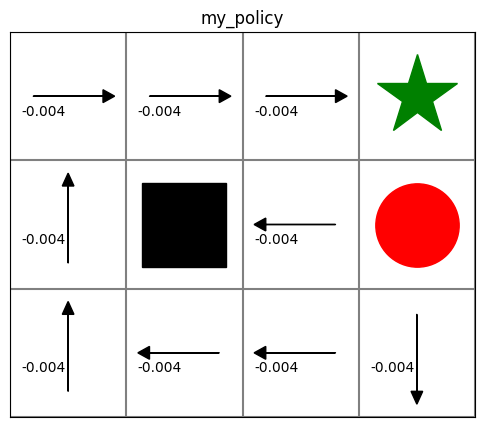

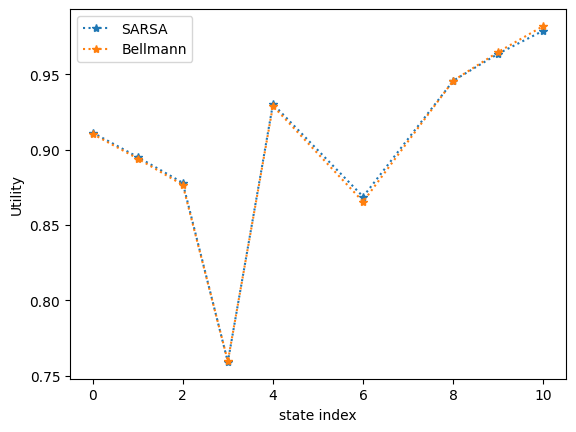

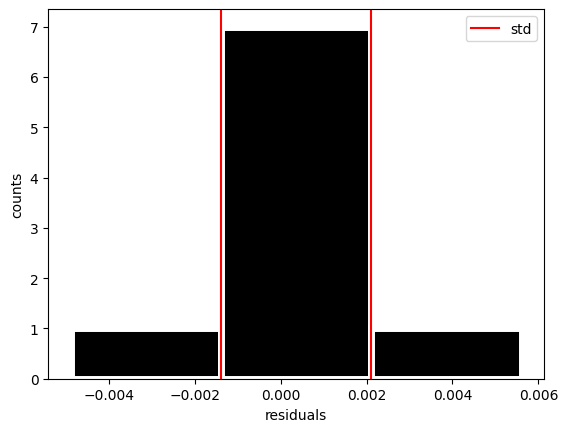

<Figure size 640x480 with 0 Axes>

In [22]:
policy_SARSA = np.zeros(12)
for i in range(12):
  policy_SARSA[i] = np.argmax(Q[i,:])

plot_policy(policy_SARSA)
plt.figure()
plot_U_SARSA = [np.max(Q[j,:]) for j in range(12)]

plot_U_SARSA_CORRECT= plot_U_SARSA[0:5]

plot_U_SARSA_CORRECT.append(plot_U_SARSA[6])
plot_U_SARSA_CORRECT.extend(plot_U_SARSA[8:11]) #EXCLUDE FINAL STATES DURING THE ANALISYS

print(plot_U_SARSA_CORRECT)
U_final_CORRECT= U_final[0:5].tolist()
U_final_CORRECT.append(U_final[6])
U_final_CORRECT.extend(U_final[8:11])

index_CORRECT = [0,1,2,3,4,6,8,9,10]

plt.plot(index_CORRECT,plot_U_SARSA_CORRECT, marker="*", linestyle =":", label="SARSA")
plt.plot(index_CORRECT, U_final_CORRECT, marker="*",linestyle = ":",label="Bellmann")
plt.xlabel("state index")
plt.ylabel("Utility")
plt.legend()
print(plot_U_SARSA)

std_SARSA = 0.0
avg_SARSA =0.0
residuals_SARSA = []
for j in range(12):
  if (j not in OBSTACLES_indexes) and (j not in ALIVE_indexes) and (j not in DEATH_indexes):
    std_SARSA += (plot_U_SARSA[j]-U_final[j])**2
    avg_SARSA +=plot_U_SARSA[j] - U_final[j]
    residuals_SARSA.append(plot_U_SARSA[j] - U_final[j])
std_SARSA = np.sqrt(std_SARSA/9.0)
avg_SARSA = avg_SARSA/9.0
plt.figure()
plt.hist(residuals_SARSA, bins = [avg_SARSA-3*std_SARSA, avg_SARSA - std_SARSA, avg_SARSA + std_SARSA, avg_SARSA + 3 * std_SARSA], edgecolor='white', linewidth=5, color = "black")
plt.xlabel("residuals")
plt.ylabel("counts")
plt.axvline(avg_SARSA+std_SARSA, color="red", label ="std")
plt.axvline(avg_SARSA-std_SARSA,color="red")
plt.legend()

print("RESIDUALS with BELLMANN: ", avg_SARSA, "+-", std_SARSA)


plt.figure()

Another type of plot

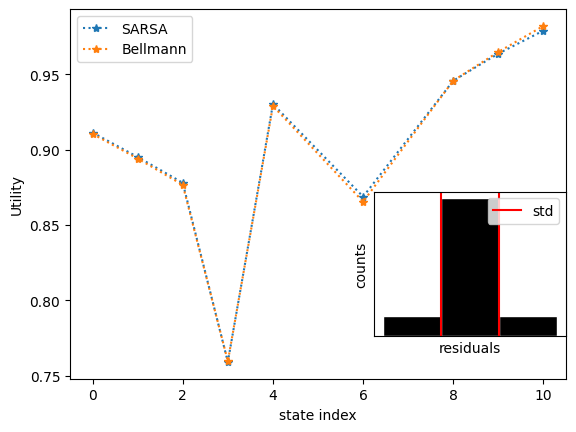

In [23]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Creazione del primo grafico
fig, ax1 = plt.subplots()
ax1.plot(index_CORRECT, plot_U_SARSA_CORRECT, marker="*", linestyle=":", label="SARSA")
ax1.plot(index_CORRECT, U_final_CORRECT, marker="*", linestyle=":", label="Bellmann")
ax1.set_xlabel("state index")
ax1.set_ylabel("Utility")
ax1.legend()


'''
# Creazione della seconda figura come un inset
ax_inset = inset_axes(ax1, width="30%", height="30%", loc='lower right', bbox_to_anchor=(6, 0.1, 10, 0.1))  # posizionamento dell'inset
ax_inset.hist(residuals, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=1, color="black")
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="red", label="std")
ax_inset.axvline(avg_SARSA-std_SARSA, color="red")
ax_inset.set_yticks([])
ax_inset.legend()
'''
# Creazione della seconda figura come un inset manuale
# Gli argomenti sono: [left, bottom, width, height] in percentuale della figura principale
ax_inset = fig.add_axes([0.6, 0.2, 0.3, 0.3])
ax_inset.hist(residuals_SARSA, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=1, color="black")
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="red", label="std")
ax_inset.axvline(avg_SARSA-std_SARSA, color="red")
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.legend()

### 2.2)Q-LEARNING ###

In [24]:

epsilon = epsilon_0
alpha = alpha_0

Q = np.zeros((Nx * Ny, 4))
#NTIMES = 100
step =0
step_decay_rate=0
UTILITY3_Q_LEARNING = np.zeros(num_episodes) #also in this case I want to save the utility of 3 and 10 states to make after a data analysis
UTILITY10_Q_LEARNING = np.zeros(num_episodes)

step_decay_rate = 0
for i in range(num_episodes):
  state_t = random_state() #extract a random state
  step+=1
  step_decay_rate+=1
  #epsilon=1./(i+1)
  if epsilon > epsilon_min_Q:
    if step >= epsilon_decay_steps:
      step = 0
     # epsilon = epsilon/2.0
      epsilon = np.max([epsilon_0-(i/max_step_epsilon_min),0.0])
  if alpha > alpha_min_Q_LEARNING:
    if step_decay_rate >= Decay_rate_max_step:
      step_decay_rate = 0
      alpha = alpha/2.0

  for j in range(N_times):
    if np.random.rand()<epsilon:
      action_t = int(np.random.random() * 4)
    else:
      action_t = np.argmax(Q[state_t,:])

    state_t1 = Next_position(state_t,action_t)

    r_t1 = R[state_t1]
    Q[state_t,action_t] = Q[state_t,action_t] + alpha * (r_t1 + Gamma * np.max(Q[state_t1,:]) - Q[state_t,action_t])
    state_t = state_t1
    if  (state_t in OBSTACLES_indexes) or (state_t in ALIVE_indexes) or (state_t in DEATH_indexes):
      break
  UTILITY3_Q_LEARNING[i] = np.max(Q[3,:])
  UTILITY10_Q_LEARNING[i] = np.max(Q[10,:])

Policy

[0.9128862854371553, 0.895553472674405, 0.8770958126721742, 0.763618149416917, 0.9309147913343676, 0.0, 0.8626989520816093, 0.0, 0.9496567716657203, 0.9690421644704572, 0.9799404571322415, 0.0]


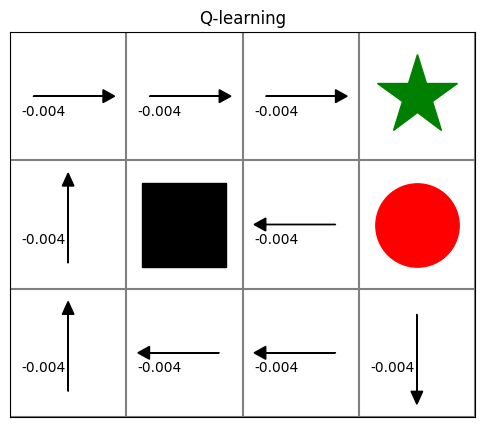

In [25]:
policy_Q_LEARNING = np.zeros(12)
for i in range(12):
  policy_Q_LEARNING[i] = np.argmax(Q[i,:])
plot_policy(policy_Q_LEARNING, title = "Q-learning")
plot_U_Q_LEARNING = [np.max(Q[j,:]) for j in range(12)]

plot_U_Q_LEARNING_CORRECT= plot_U_Q_LEARNING[0:5]

plot_U_Q_LEARNING_CORRECT.append(plot_U_Q_LEARNING[6])
plot_U_Q_LEARNING_CORRECT.extend(plot_U_Q_LEARNING[8:11]) #EXCLUDE FINAL STATES DURING THE ANALISYS

print(plot_U_Q_LEARNING)

std_Q_LEARNING = 0.0
avg_Q_LEARNING = 0.0
residuals_Q_LEARNING = []
for j in range(12):  #evaluate the quadratic error and avg respect to the Bellman one
  if (j not in OBSTACLES_indexes) and (j not in ALIVE_indexes) and (j not in DEATH_indexes):
    std_Q_LEARNING += (plot_U_Q_LEARNING[j]-U_final[j])**2
    avg_Q_LEARNING +=plot_U_Q_LEARNING[j] - U_final[j]
    residuals_Q_LEARNING.append(plot_U_Q_LEARNING[j] - U_final[j])
std_Q_LEARNING = np.sqrt(std_Q_LEARNING/9.0)
avg_Q_LEARNING = avg_Q_LEARNING/9.0


### 2.3)ANALYSIS OF SARSA and Q-LEARNING ###

#### Function of a triple plot (BELLMAN, SARSA AND Q-LEARNING) ####

In [26]:
def triple_plot(policy_bellmann, policy_SARSA, policy_QLearning, Alive_indexes = [11], Death_indexes = [7], Obstacles_indexes = [5], Nx = 4, Ny = 3):
    plt.figure(figsize = (13,4.5))

    plt.subplot(1,3,1)
    plt.xlim(-0.5,+Nx- 0.5)
    plt.ylim(-0.5,Ny-0.5)
    plt.xticks([])
    plt.yticks([])

    #build the grid
    for i in range(0,Ny+1):
        plt.axhline(i-0.5,color = "gray")

    for i in range(0,Nx+1):
        plt.axvline(i-0.5,color = "gray")

    #plot obstacoles and winning / losing states
    for i in Obstacles_indexes:
        plt.plot(i%Nx , int(i/Nx), marker = "s", markersize = 40, color = "black")
    for i in Alive_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "*", markersize = 40, color = "green")
    for i in Death_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "o", markersize = 40, color = "red")

    for i in range(len(policy_bellmann)):
        if (i not in Alive_indexes) and (i not in Death_indexes) and (i not in Obstacles_indexes):
            plt.text(i%Nx-0.4, int(i/Nx)-0.15, str(r))

            if policy_bellmann[i] == 0: #up
                plt.arrow(i%Nx, int(i/Nx)-0.3, 0, +0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_bellmann[i] == 1: #right
                plt.arrow(i%Nx-0.3, int(i/Nx), +0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_bellmann[i] == 2: #down
                plt.arrow(i%Nx, int(i/Nx)+0.3, 0, -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_bellmann[i] == 3: #left
                plt.arrow(i%Nx+0.3, int(i/Nx), -0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up
    title = "Bellmann"
    plt.title(title)

    plt.subplot(1,3,2)
    plt.xlim(-0.5,+Nx- 0.5)
    plt.ylim(-0.5,Ny-0.5)
    plt.xticks([])
    plt.yticks([])

    #build the grid
    for i in range(0,Ny+1):
        plt.axhline(i-0.5,color = "gray")

    for i in range(0,Nx+1):
        plt.axvline(i-0.5,color = "gray")

    #plot obstacoles and winning / losing states
    for i in Obstacles_indexes:
        plt.plot(i%Nx , int(i/Nx), marker = "s", markersize = 40, color = "black")
    for i in Alive_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "*", markersize = 40, color = "green")
    for i in Death_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "o", markersize = 40, color = "red")

    for i in range(len(policy_SARSA)):
        if (i not in Alive_indexes) and (i not in Death_indexes) and (i not in Obstacles_indexes):
            plt.text(i%Nx-0.4, int(i/Nx)-0.15, str(r))

            if policy_SARSA[i] == 0: #up
                plt.arrow(i%Nx, int(i/Nx)-0.3, 0, +0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_SARSA[i] == 1: #right
                plt.arrow(i%Nx-0.3, int(i/Nx), +0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_SARSA[i] == 2: #down
                plt.arrow(i%Nx, int(i/Nx)+0.3, 0, -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_SARSA[i] == 3: #left
                plt.arrow(i%Nx+0.3, int(i/Nx), -0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up
    title = "SARSA"
    plt.title(title)

    plt.subplot(1,3,3)
    plt.xlim(-0.5,+Nx- 0.5)
    plt.ylim(-0.5,Ny-0.5)
    plt.xticks([])
    plt.yticks([])

    #build the grid
    for i in range(0,Ny+1):
        plt.axhline(i-0.5,color = "gray")

    for i in range(0,Nx+1):
        plt.axvline(i-0.5,color = "gray")

    #plot obstacoles and winning / losing states
    for i in Obstacles_indexes:
        plt.plot(i%Nx , int(i/Nx), marker = "s", markersize = 40, color = "black")
    for i in Alive_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "*", markersize = 40, color = "green")
    for i in Death_indexes:
        plt.plot(i%Nx , int(i/Nx) , marker = "o", markersize = 40, color = "red")

    for i in range(len(policy_QLearning)):
        if (i not in Alive_indexes) and (i not in Death_indexes) and (i not in Obstacles_indexes):
            plt.text(i%Nx-0.4, int(i/Nx)-0.15, str(r))

            if policy_QLearning[i] == 0: #up
                plt.arrow(i%Nx, int(i/Nx)-0.3, 0, +0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_QLearning[i] == 1: #right
                plt.arrow(i%Nx-0.3, int(i/Nx), +0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_QLearning[i] == 2: #down
                plt.arrow(i%Nx, int(i/Nx)+0.3, 0, -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black') #up

            if policy_QLearning[i] == 3: #left
                plt.arrow(i%Nx+0.3, int(i/Nx), -0.6, +0.0, head_width=0.1, head_length=0.1, fc='black', ec='black') #up
    title = "Q-Learning"
    plt.title(title)

    plt.savefig("triple_plot_policy.pdf")




#### Tests of policies ####


In [27]:
def simulate_random_walk(policy,number_steps): #return in output the utility of a single episode
  #s = random_state()
  s=0
  factor = 1.0
  output=0.0
  for j in range(number_steps):
    action = policy[s]
    s = Next_position(s,action)
    output += factor * R[s]
    factor = factor*Gamma
    if (s in OBSTACLES_indexes) or (s in ALIVE_indexes) or (s in DEATH_indexes):
      break
  return output
simulate_random_walk(policy,100)

0.9180722091613999

In [28]:
#policy
mean_Utility_BELLMANN = 0.0
mean_Utility_SARSA = 0.0
mean_Utility_Q_LEARNING = 0.0

std_Utility_BELLMANN = 0.0
std_Utility_SARSA = 0.0
std_Utility_Q_LEARNING = 0.0

number_of_episodes_test = 30000
number_of_steps_test = 100
for i in range(number_of_episodes_test):
  walk_BELLMANN = simulate_random_walk(policy,number_of_steps_test)
  walk_SARSA = simulate_random_walk(policy_SARSA,number_of_steps_test)
  walk_Q_LEARNING = simulate_random_walk(policy_Q_LEARNING,number_of_steps_test)

  mean_Utility_BELLMANN += walk_BELLMANN
  mean_Utility_SARSA += walk_SARSA
  mean_Utility_Q_LEARNING += walk_Q_LEARNING

  std_Utility_BELLMANN += walk_BELLMANN * walk_BELLMANN
  std_Utility_SARSA += walk_SARSA * walk_SARSA
  std_Utility_Q_LEARNING += walk_Q_LEARNING * walk_Q_LEARNING


mean_Utility_BELLMANN /= number_of_episodes_test
mean_Utility_SARSA /= number_of_episodes_test
mean_Utility_Q_LEARNING /= number_of_episodes_test

std_Utility_BELLMANN = std_Utility_BELLMANN/number_of_episodes_test - mean_Utility_BELLMANN*mean_Utility_BELLMANN
std_Utility_SARSA = std_Utility_SARSA/number_of_episodes_test - mean_Utility_SARSA*mean_Utility_SARSA
std_Utility_Q_LEARNING = std_Utility_Q_LEARNING/number_of_episodes_test - mean_Utility_Q_LEARNING*mean_Utility_Q_LEARNING

std_Utility_BELLMANN = np.sqrt(std_Utility_BELLMANN)/np.sqrt(number_of_episodes_test)
std_Utility_SARSA = np.sqrt(std_Utility_SARSA)/np.sqrt(number_of_episodes_test)
std_Utility_Q_LEARNING = np.sqrt(std_Utility_Q_LEARNING)/np.sqrt(number_of_episodes_test)


In [29]:
def test_compatibility(x,y,sigma_x,sigma_y): #x and y are means, sigma_x and sigma_y are errors of means. GAUSSIAN TEST
  t0 = (x-y)/np.sqrt(sigma_x*sigma_x + sigma_y * sigma_y)
  limit = 3.291
  if abs(t0)<limit:
    output_1 = "compatible"
  else:
    output_1 = "not compatible"
  output_2 = t0
  return output_1,output_2



In [30]:
print("Utility BELLMANN = ", mean_Utility_BELLMANN, "+-", std_Utility_BELLMANN)
print("Utility SARSA = ", mean_Utility_SARSA, "+-", std_Utility_SARSA)
print("Utility Q_LEARNING = ", mean_Utility_Q_LEARNING, "+-", std_Utility_Q_LEARNING)

TEST_SARSA,t0_SARSA = test_compatibility(mean_Utility_SARSA,mean_Utility_BELLMANN,std_Utility_SARSA,std_Utility_BELLMANN)
print("Sarsa is",TEST_SARSA, "with t0=",t0_SARSA)
TEST_Q_LEARNING,t0_Q_LEARNING = test_compatibility(mean_Utility_Q_LEARNING,mean_Utility_BELLMANN,std_Utility_Q_LEARNING,std_Utility_BELLMANN)
print("Q_LEARNING is",TEST_Q_LEARNING, "with t0=",t0_Q_LEARNING)
if abs(t0_Q_LEARNING)>abs(t0_SARSA):
  print("SARSA IS BETTER")
else:
  print("Q_LEARNING IS BETTER")


Utility BELLMANN =  0.9106185179413167 +- 0.00032366243398163465
Utility SARSA =  0.9103843735467232 +- 0.0003338108732468714
Utility Q_LEARNING =  0.9098105363548071 +- 0.00033433023207991153
Sarsa is compatible with t0= -0.5035805029084922
Q_LEARNING is compatible with t0= -1.736354267453877
SARSA IS BETTER


RESIDUALS with BELLMANN: 
 SARSA:  0.00036096025084813514 +- 0.001749336195946521 
 Q-LEARNING:  0.0015257660792505777 +- 0.002872233923821668


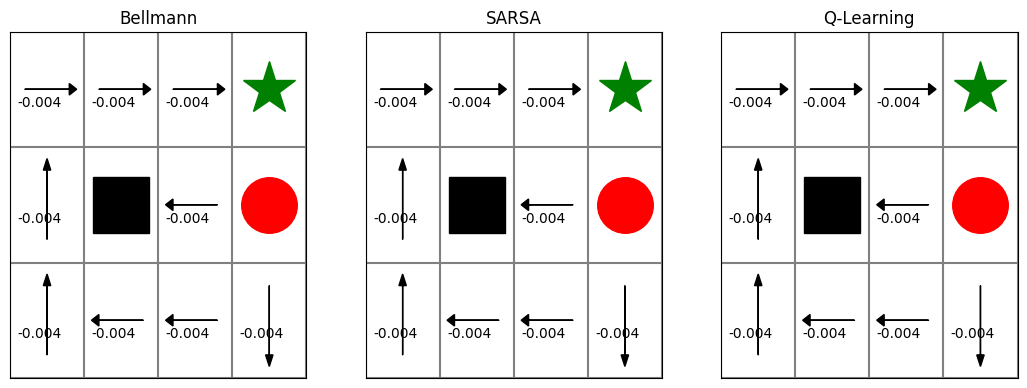

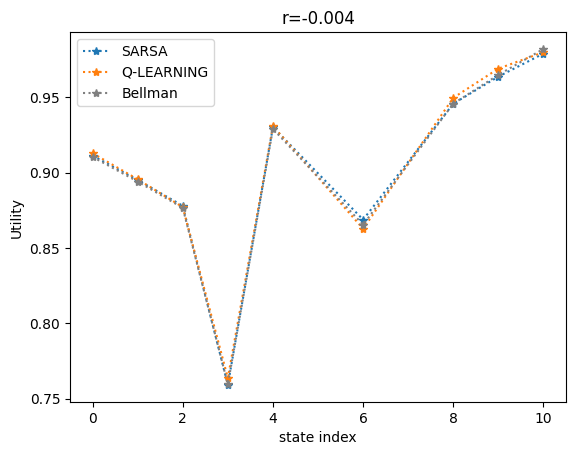

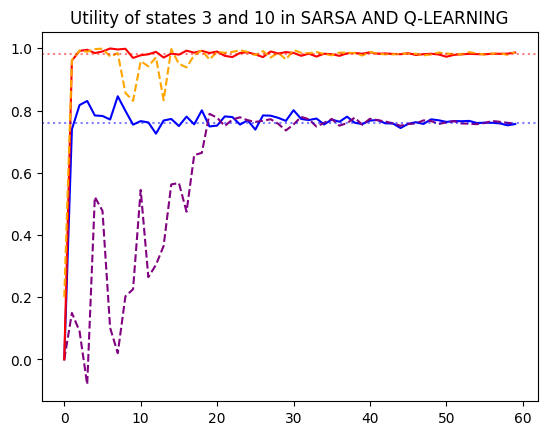

In [31]:
triple_plot(policy, policy_SARSA, policy_Q_LEARNING)
print("RESIDUALS with BELLMANN: \n SARSA: ", avg_SARSA, "+-", std_SARSA, "\n Q-LEARNING: ", avg_Q_LEARNING, "+-", std_Q_LEARNING)
plt.figure()
plt.plot(index_CORRECT,plot_U_SARSA_CORRECT, marker="*", linestyle =":", label="SARSA")
plt.plot(index_CORRECT,plot_U_Q_LEARNING_CORRECT, marker="*", linestyle =":", label="Q-LEARNING")
plt.plot(index_CORRECT, U_final_CORRECT, marker="*",linestyle = ":",label="Bellman", color = "gray")
plt.xlabel("state index")
plt.ylabel("Utility")
plt.legend()
title = "r="+ f'{r:,}'
plt.title(title)
plt.savefig("Utility.pdf")

plt.figure()
plt.title("Utility of states 3 and 10 in SARSA AND Q-LEARNING")
plt.plot(UTILITY3_Q_LEARNING[::500],color="blue")
plt.plot(UTILITY3_SARSA[::500],color = "purple",linestyle="--")
plt.plot(UTILITY10_Q_LEARNING[::500],color="red")
plt.plot(UTILITY10_SARSA[::500],color = "orange",linestyle="--")

plt.axhline(U[3],color="blue",linestyle=":",alpha=0.5)
plt.axhline(U[10],color="red",linestyle=":",alpha=0.5)

Plot with residuals

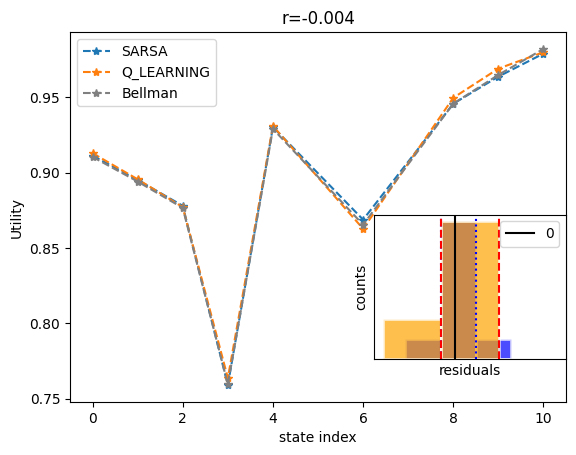

In [32]:
fig, ax1 = plt.subplots()
ax1.plot(index_CORRECT, plot_U_SARSA_CORRECT, marker="*", linestyle="--", label="SARSA")
ax1.plot(index_CORRECT, plot_U_Q_LEARNING_CORRECT, marker="*", linestyle="--", label="Q_LEARNING")
ax1.plot(index_CORRECT, U_final_CORRECT, marker="*", linestyle="--", label="Bellman",color = "gray")
ax1.set_xlabel("state index")
ax1.set_ylabel("Utility")
ax1.legend()

plt.title(title)

'''
# Creazione della seconda figura come un inset
ax_inset = inset_axes(ax1, width="30%", height="30%", loc='lower right', bbox_to_anchor=(6, 0.1, 10, 0.1))  # posizionamento dell'inset
ax_inset.hist(residuals, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=1, color="black")
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="red", label="std")
ax_inset.axvline(avg_SARSA-std_SARSA, color="red")
ax_inset.set_yticks([])
ax_inset.legend()
'''
# Creazione della seconda figura come un inset manuale
# Gli argomenti sono: [left, bottom, width, height] in percentuale della figura principale
ax_inset = fig.add_axes([0.6, 0.2, 0.3, 0.3])
ax_inset.hist(residuals_SARSA, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=2, color="blue", alpha = 0.7)
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="blue", linestyle = ":")
ax_inset.axvline(avg_SARSA-std_SARSA, color="blue", linestyle = ":")
ax_inset.set_xticks([])
ax_inset.set_yticks([])

ax_inset.hist(residuals_Q_LEARNING, bins=[avg_Q_LEARNING-3*std_Q_LEARNING, avg_Q_LEARNING-std_Q_LEARNING, avg_Q_LEARNING+std_Q_LEARNING, avg_Q_LEARNING+3*std_Q_LEARNING], edgecolor='white', linewidth=2, color="orange",alpha =0.7)
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(0, color="black", label="0")
ax_inset.axvline(avg_Q_LEARNING+std_Q_LEARNING, color="red",  linestyle = "--")
ax_inset.axvline(avg_Q_LEARNING-std_Q_LEARNING, color="red", linestyle = "--")

ax_inset.legend()
fig.savefig("Utility.pdf")


# DEEP Q LEARNING #


In [33]:
#parameters of Deep Q network
OH = True  #IF OH is True the one-hot-encoding state is activated(image of 11 entries), otherwise it is used an encoding [x,y] (i.e. with 2 entries)

## Some useful functions ##

In [34]:
def position_to_index(s): 
  x = s[0]
  y = s[1]
  index = x + Nx * y
  return index

def index_to_position(index):
  x = index % Nx
  y = int(index / Nx)
  return np.array([x,y])

One hot encoding state

In [35]:
Nx = 4
Ny=3
def one_hot_encode(i, width=Nx, height=Ny):
    """
    Returns:
    ONE-HOT ENCODED VECTOR OF DIMENSION (width * height) FROM THE POSITION.
    """
    i = int(i)
    vec = index_to_position(i)
    vec=np.array(vec)
    vec=vec.astype(int)
    state_index = vec[1] * width + vec[0]
    obstacle_index=1*width+1
    one_hot_vector = np.ones(width * height).astype(float)/100.0*0

    one_hot_vector[state_index] = 1.0
    return one_hot_vector

# Esempio di utilizzo
width = Nx  # Numero di colonne
height = Ny  # Numero di righe

# Converti (x, y) in un vettore one-hot
one_hot_vector = one_hot_encode(7, width, height)

# Stampa il vettore one-hot
print(one_hot_vector)


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Preparation of the input of DNN

In [37]:

def prepare_state(index, OH=True): #Prepare the state depending if OH is True or False
  if OH:
    output = torch.tensor(one_hot_encode(index)).float()
  else:
    x = index % Nx
    y = int(index / Nx)
    output = torch.tensor([x,y]).float()
  return output


def sample_random_batch(D,batch_len): 
  '''
  Extract a random batch of lenght batch_len from the replay memory D
  '''
  output = []
  for i in range(batch_len):
    random_index = int(np.random.rand()*len(D))
    output.append(D[random_index])
  return output

## DEEP Q N ARCHITECTURE ##

In [38]:

class ShallowMLP(nn.Module):
  def __init__(self, input_dim=Nx*Ny, output_dim=4, hidden_dim=1, factor = 4.0, unif_init = False): 

    super(ShallowMLP, self).__init__()

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)


    self.layer1 = nn.Linear(input_dim,hidden_dim) #first layer
    self.activ1=nn.ReLU()

    self.layer2 =nn.Linear(hidden_dim,hidden_dim)#second layer
    self.layer3 =nn.Linear(hidden_dim,hidden_dim)#third layer
    self.activ2=nn.ReLU()
    self.layer4 = nn.Linear(hidden_dim,hidden_dim)#output layer
    self.activ3=nn.ReLU()

    self.activ4=nn.ReLU()
    self.layer5 = nn.Linear(hidden_dim,output_dim)#output layerù
    if unif_init:
      '''
      torch.nn.init.uniform_(self.layer1.weight,a=-1./(hidden_dim/factor), b=1./(hidden_dim/factor))
      torch.nn.init.uniform_(self.layer2.weight,a=-1./(hidden_dim/factor), b=1./(hidden_dim/factor))
      torch.nn.init.uniform_(self.layer3.weight,a=-1./(hidden_dim/factor), b=1./(hidden_dim/factor))
      torch.nn.init.uniform_(self.layer4.weight,a=-1./(hidden_dim/factor), b=1./(hidden_dim/factor))
      torch.nn.init.uniform_(self.layer5.weight,a=-1./(hidden_dim/factor), b=1./(hidden_dim/factor))
      '''
      torch.nn.init.kaiming_uniform_(self.layer1.weight, a=0, mode='fan_out', nonlinearity='relu', generator=None)
      torch.nn.init.kaiming_uniform_(self.layer2.weight, a=0, mode='fan_out', nonlinearity='relu', generator=None)
      torch.nn.init.kaiming_uniform_(self.layer3.weight, a=0, mode='fan_out', nonlinearity='relu', generator=None)
      torch.nn.init.kaiming_uniform_(self.layer4.weight, a=0, mode='fan_out', nonlinearity='relu', generator=None)
      torch.nn.init.kaiming_uniform_(self.layer5.weight, a=0, mode='fan_out', nonlinearity='relu', generator=None)
    '''
      torch.nn.init.xavier_uniform_(self.layer1.weight, gain=1.0, generator=None)
      torch.nn.init.xavier_uniform_(self.layer2.weight, gain=1.0, generator=None)
      torch.nn.init.xavier_uniform_(self.layer3.weight, gain=1.0, generator=None)
      torch.nn.init.xavier_uniform_(self.layer4.weight, gain=1.0, generator=None)
      torch.nn.init.xavier_uniform_(self.layer5.weight, gain=1.0, generator=None)
    self.Softmax = nn.Softmax()
    '''
  def forward(self, x):

    out=self.layer1(x)
    out=self.activ1(out)
    out=self.layer2(out)


    #out=self.activ2(out)

    #out=self.layer3(out)

    #out=self.activ3(out)



    #out=self.layer4(out)

    self.activ4(out)
    out = self.layer5(out)
    return out

In [39]:
# printout del modello

model = ShallowMLP()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(2))
else:
  summary(model, input_size=(1,Nx*Ny))
from torch import optim

ShallowMLP(
  (layer1): Linear(in_features=12, out_features=1, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=1, out_features=1, bias=True)
  (layer3): Linear(in_features=1, out_features=1, bias=True)
  (activ2): ReLU()
  (layer4): Linear(in_features=1, out_features=1, bias=True)
  (activ3): ReLU()
  (activ4): ReLU()
  (layer5): Linear(in_features=1, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]              13
              ReLU-2                 [-1, 1, 1]               0
            Linear-3                 [-1, 1, 1]               2
              ReLU-4                 [-1, 1, 1]               0
            Linear-5                 [-1, 1, 4]               8
Total params: 23
Trainable params: 23
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

See output of the architecture to adjust "factor" (normalization of weights if torch.nn.init.uniform is used)

In [40]:
model = ShallowMLP(input_dim=12, output_dim=4)

# Creazione di un batch di 16 dati di input
batch_size = 16
input_data = torch.randn(batch_size, 12)  # Genera un batch di dati casuali

# Passaggio del batch attraverso la rete
output = model(input_data)

# Stampa dell'output
print(output)

tensor([[ 1.0638, -0.6674, -0.1107, -0.2098],
        [ 0.9743, -0.5971, -0.1361, -0.1289],
        [ 1.1805, -0.7590, -0.0777, -0.3152],
        [ 0.8739, -0.5183, -0.1645, -0.0382],
        [ 0.8979, -0.5371, -0.1577, -0.0598],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.9303, -0.5626, -0.1486, -0.0891],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 1.1461, -0.7320, -0.0875, -0.2840],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 0.8648, -0.5112, -0.1671, -0.0300],
        [ 1.1019, -0.6973, -0.1000, -0.2441]], grad_fn=<AddmmBackward0>)


## Training Loop ##


In [41]:
def phi_to_s(phi, OH = False): #useful to map from 2d grid to 1d array
  if OH==False:
    phi = np.array(phi)
    s = phi[0]+ Nx*phi[1] #IF OH is false so the encoding of the state is phi= [x,y]. So the index of state is x + Nx y
  else:
    s = np.argmax(phi)  #IF OH IS TRUE, The state index is the argmax of the image
    #print(phi)
  return int(s)

In [42]:
print(phi_to_s([0,1]))
print(phi_to_s(one_hot_encode(2),))

4
0


In [45]:
from torch import optim

gamma=Gamma
OH=True
unif_init = True
input_dim = 2
if OH==True:
  input_dim=12
hidden_dim =32 #32 1 HIDDEN LAYER
num_games = 30000 #number of episodes
max_time = 200 #max Number of steps for each episode
#epsilon = 1.0
#epsilon_decay_factor = 0.8
#epsilon_min = 0.00
epsilon_0=0.6
C=40 #Number of episodes befor updating the target network
L_R=0.007
final_LR=0.0001
FACTOR_LR = 0.95 #Decaying of LR
factor_init = 1.5 #for initialization of the uniform distribution of weights
len_batch=2 #4
epsilon_min_deep_Q_learning = 0.001


loss_raw_array=[]
c=0

Q = ShallowMLP(input_dim = input_dim, hidden_dim = hidden_dim,factor = factor_init, unif_init=unif_init)
Q_before = ShallowMLP(input_dim = input_dim, hidden_dim = hidden_dim,factor = factor_init)

Q_before.load_state_dict(Q.state_dict()) #initialize Q_before with the Q weights

Q_copy = ShallowMLP(input_dim = input_dim, hidden_dim = hidden_dim,factor = factor_init)
Q_copy.load_state_dict(Q.state_dict()) #initialize Q_before with the Q weights

opt = torch.optim.Adam(Q.parameters(), lr=L_R)

my_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=FACTOR_LR)
#Lr_rate_decay = 0.8
#Lr_steps_decay = 20


loss_fnc = nn.MSELoss()
#loss_fnc = nn.L1Loss()
loss_games = []
loss_game = 0.0
cntr=0
games_reward = []


N = 800 #Lenght of replay memory
count = 0
D=[]
#initialize a random replay memory
while True:
  if count>=N:
    break
  s_i = random_state()
  while True:
    action = int(np.random.rand()*4)
    s_f = Next_position(s_i,action)
    reward = R[s_f]
    D.append([prepare_state(s_i,OH=OH),action,reward,prepare_state(s_f,OH=OH)])
    count = count + 1
    if count>=N:
      break
    if (s_f in ALIVE_indexes) or (s_f in DEATH_indexes):
      break
    s_i = s_f


print(len(D))
print(D)
CONTROL_Q=[]
CONTROL_QBAD=[]
CONTROL_U3=[]
CONTROL_U10=[]


MSE_array = []

for m in range(num_games):
  #choose a random state
  s_1 = random_state()
  #s_1=0
  reward_history=[]
  game_reward = 0.0
  for time in range(max_time):
    opt.zero_grad()

    phi_1 = prepare_state(s_1 ,OH=OH)
    #1. choose an action
    random_number = np.random.rand()
    if random_number<epsilon:
      a = int(np.random.rand()*4)
    else:
      a = torch.argmax(Q(phi_1)).item()
     # print(a,Q_copy(phi_1))
     # print(a)
    #observe reward and image
    s_2 = Next_position(s_1,a)
    reward = R[s_2]
    #print(s_1,a,s_2,reward)
    phi_2 = prepare_state(s_2, OH = OH)
    s_1 = s_2 #reset the state
    D.append([phi_1,a,reward,phi_2]) #store in the replay memory
    if len(D)>=N:
      D.pop(0)   #eliminate too old memories

    #sample minibatch from D

    Q.train()
    batch = sample_random_batch(D, len_batch)
    loss=0.0
    for j in range(len_batch):
      phi_j, action_j, reward_j, phi_jf = batch[j][0],batch[j][1],batch[j][2],batch[j][3]
      s_j = phi_to_s(phi_j, OH = OH)
      s_jf = phi_to_s(phi_jf, OH = OH)
      #print(s_jf, phi_jf)
      if (s_jf in ALIVE_indexes) or (s_jf in DEATH_indexes):
        y = torch.tensor(reward_j,dtype = float)
        #print("ALIVE OR DEATH")
      else:
        y = reward_j + gamma * torch.max(Q_before(phi_jf))
      #if s_j==10 and action_j ==1:
        #print(y,Q(phi_j)[action_j]
      pred=Q(phi_j)[action_j]
      loss +=loss_fnc(pred,y.float())
    loss.backward()
    opt.step()


    loss_raw_array.append(loss.item())

    loss_game+=loss.item()
    reward_history.append(reward)
    cntr+=1

    if (s_2 in ALIVE_indexes) or (s_2 in DEATH_indexes):
      break

  for esponent in range(len(reward_history)):
    game_reward += reward_history[esponent]*gamma**esponent
  games_reward.append(game_reward)
  loss_games.append(loss_game/cntr)

  c+=1
  epsilon = np.max([epsilon_0 - (float(m+1)/num_games*2),epsilon_min_deep_Q_learning])

  if c>=C:
    Q_before.load_state_dict(Q.state_dict()) #Q_before with the Q weights
    c=0
    policy_control=[]
    Q.eval()
    for control in range(12):
      phi_control=prepare_state(control,OH=OH)
      policy_control.append(torch.argmax(Q(phi_control)).item())
    Q10 = Q(prepare_state(10,OH=OH))[1].item()
    Q3 = Q(prepare_state(3,OH=OH))[0].item()
    CONTROL_Q.append(Q10)
    CONTROL_QBAD.append(Q3)


    U10 = torch.max(Q(prepare_state(10,OH=OH))).item()
    U3 = torch.max(Q(prepare_state(3,OH=OH))).item()
    CONTROL_U3.append(U3)
    CONTROL_U10.append(U10)
    print(f"______________\nUPDATE Q! Policy Control = {policy_control}\nQ_good = {Q10:.4f}, Q_bad = {Q3:.4f}, U_GOOD = {U10:.10f} U_bad = {U3:.10f}\n________________")
    
    MSE_tmp=0.0
    for d in range(12):
      ARRAY_TMP=[]
      my_U_DQN=0.0
      state_prova=prepare_state(d,OH=True)
      for action_tmp in range(4):
        ARRAY_TMP.append(Q(state_prova)[action_tmp].item())
      my_U_DQN = np.max(ARRAY_TMP)
      MSE_tmp +=(my_U_DQN - U_final[d])**2/9.0
    
    print("MSE = ",MSE_tmp)
    MSE_array.append(MSE_tmp)



    if my_lr_scheduler.optimizer.param_groups[0]['lr'] > final_LR:
      my_lr_scheduler.step()

    #if epsilon > epsilon_min:
    #  epsilon = epsilon * epsilon_decay_factor

  #if m==int(num_games/2):
   # for g in opt.param_groups:
   #   g['lr'] = L_R #Give a kick to the learning rate
   # epsilon = 0.9 #Gives a kick to the epsilon

  print(f"GAME = {m}, LOSS = {loss_game/cntr:.8f}, number of steps done = {cntr}, s_finale = {s_2:.4f}, epsilon = {epsilon:.4f}, game_reward = {game_reward:.4f}, lr = {my_lr_scheduler.optimizer.param_groups[0]['lr']:.6f}")

  cntr=0
  loss_game=0.0




800
[[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 0, -0.004, tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1, -0.004, tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1, -0.004, tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 0, -0.004, tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1, -0.004, tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 1, -0.004, tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])], [tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 1, -1.0, tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])], [tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 1, -0.004, tensor([0., 0., 0., 0., 

In [46]:
'''
| o o UGOOD    :)|
| o   o       x  |
| o o o     UBAD |
'''

'\n| o o UGOOD    :)|\n| o   o       x  |\n| o o o     UBAD |\n'

MSE Plot

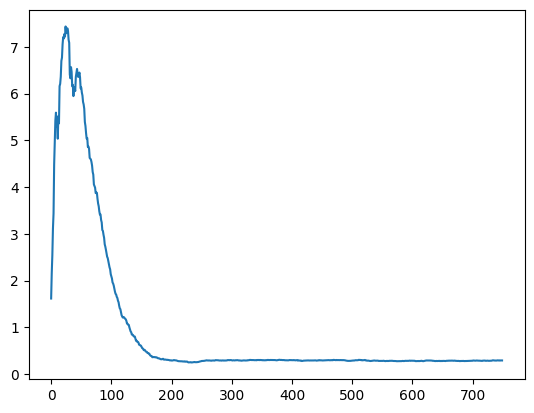

In [47]:
plt.plot(MSE_array, color = "black", label = "MSE")

# ANALYSIS #

### Convergence of utilities of states 3 and 10 of SARSA, Q-LEARNING, DEEP-Q-LEARNING ###

0.7868831157684326 0.982234001159668


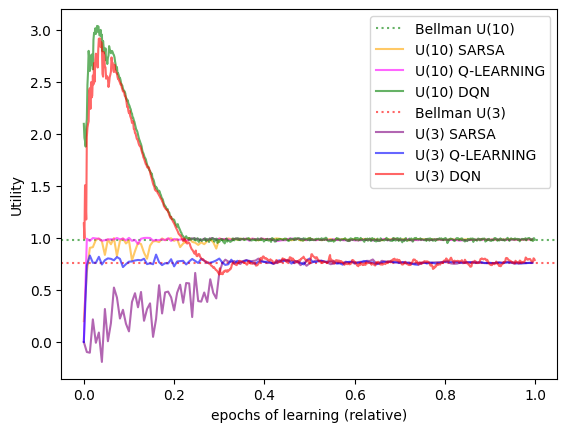

In [48]:
jump=200
U3_SARSA = UTILITY3_SARSA[::jump]
U10_SARSA = UTILITY10_SARSA[::jump]
U3_Q_LEARNING = UTILITY3_Q_LEARNING[::jump]
U10_Q_LEARNING = UTILITY10_Q_LEARNING[::jump]

x_DNN = [i/len(CONTROL_U10) for i in range(len(CONTROL_U10))]
x_SARSA = [i/len(U3_SARSA) for i in range(len(U3_SARSA))]

plt.axhline(U[10],label = "Bellman U(10)", color = "green", linestyle = ":",alpha =0.6)
plt.plot(x_SARSA,U10_SARSA,color = "orange",  label="U(10) SARSA", alpha = 0.6)
plt.plot(x_SARSA,U10_Q_LEARNING, color ="magenta", label="U(10) Q-LEARNING",alpha = 0.6)
plt.plot(x_DNN,CONTROL_U10, label = "U(10) DQN",color = "green", alpha = 0.6)
plt.axhline(U[3],label = "Bellman U(3)", color = "red", linestyle = ":", alpha = 0.6)
plt.plot(x_SARSA,U3_SARSA, color = "purple", label="U(3) SARSA",alpha = 0.6)
plt.plot(x_SARSA,U3_Q_LEARNING, color="blue", label="U(3) Q-LEARNING",alpha = 0.6)
plt.plot(x_DNN,CONTROL_U3, label= "U(3) DQN", color = "red", alpha = 0.6)


plt.legend()
plt.ylabel("Utility")
plt.xlabel("epochs of learning (relative)")
print(CONTROL_U3[len(CONTROL_U3)-1],CONTROL_U10[len(CONTROL_U10)-1])
plt.savefig("U3,U10.pdf")

### DEEP Q NETWORK LOSS AND REWARDS PLOTS ###

RAW DATA

c:\Users\andyb\anaconda3\envs\qiskit\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andyb\anaconda3\envs\qiskit\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'average of Losses on one update')

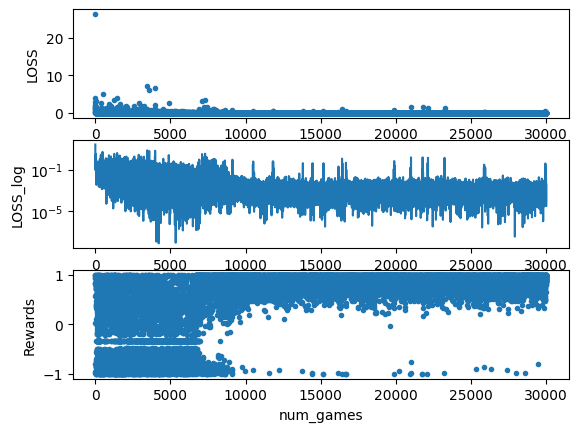

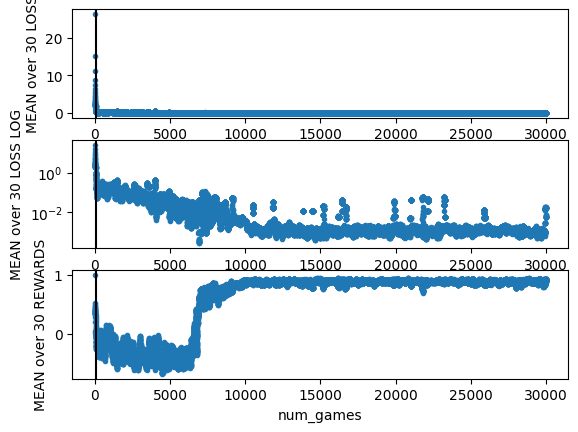

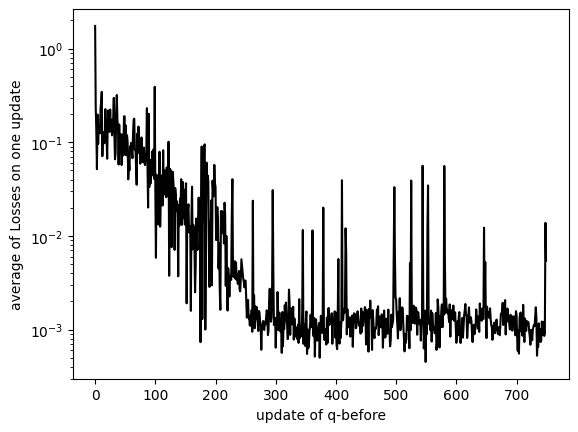

In [49]:

plt.figure(0)
plt.subplot(3,1,1)
plt.plot(loss_games, marker=".", linestyle ="")
plt.ylabel("LOSS")
plt.xlabel("num_games")
#plt.yscale("log")
plt.subplot(3,1,2)
plt.plot(loss_games)
plt.yscale("log")
plt.ylabel("LOSS_log")
plt.xlabel("num_games")
plt.subplot(3,1,3)
plt.plot(games_reward, marker=".", linestyle ="")
plt.ylabel("Rewards")
plt.xlabel("num_games")


num_means = C
loss_games_means=[]
games_reward_means = []
for i in range(len(loss_games)):
  start_index = max(i-num_means,0)
  loss_games_means.append(np.mean(loss_games[start_index:i])  )
  games_reward_means.append(np.mean(games_reward[start_index:i]) )


plt.figure(1)
plt.subplot(3,1,1)
plt.ylabel("MEAN over 30 LOSS")
plt.xlabel("num_games")
plt.plot(loss_games_means, marker=".", linestyle ="")
#plt.yscale("log")
plt.axvline(num_means, color ="black")
plt.subplot(3,1,2)
plt.plot(loss_games_means, marker=".", linestyle ="")
plt.ylabel("MEAN over 30 LOSS LOG")
plt.xlabel("num_games")
plt.yscale("log")
plt.axvline(num_means, color ="black")
plt.subplot(3,1,3)
plt.plot(games_reward_means, marker=".", linestyle ="")
plt.ylabel("MEAN over 30 REWARDS")
plt.xlabel("num_games")
plt.axvline(num_means, color ="black")

loss_games_means2 = []
result = 0.0
if int(C)==0:
  C=1
plt.figure(2)
for i in range(len(loss_games)):
  result+=loss_games[i]
  if (i+1)%int(C)==0:
    loss_games_means2.append(result/C)
    result =0.0
plt.plot(loss_games_means2[::1], marker="", linestyle ="-", color ="black")
plt.yscale("log")
plt.xlabel("update of q-before")
plt.ylabel("average of Losses on one update")

FINAL PLOTS

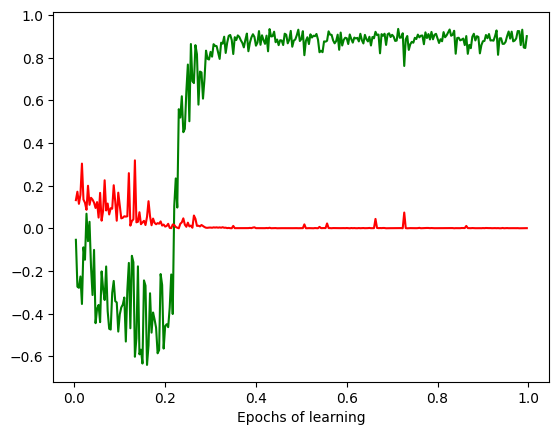

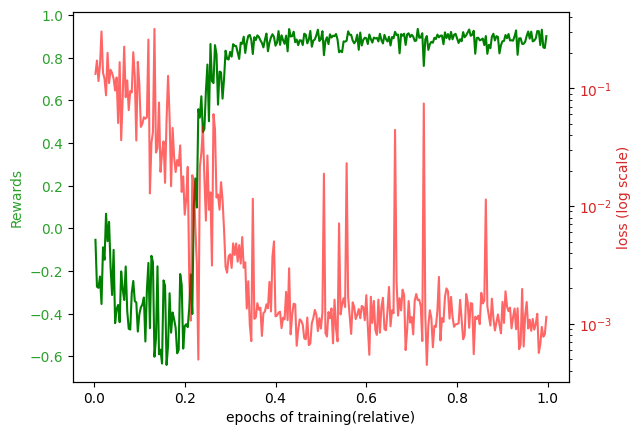

In [50]:
num_means = 30
loss_games_means=[]
games_reward_means = []
for i in range(len(loss_games)):
  start_index = max(i-num_means,0)
  loss_games_means.append(np.mean(loss_games[start_index:i])  )
  games_reward_means.append(np.mean(games_reward[start_index:i]) )

jump_reward=100
x_reward = [i/len(games_reward_means[::jump_reward]) for i in range(len(games_reward_means[::jump_reward]))]

plt.plot(x_reward,games_reward_means[::jump_reward],color="green")
plt.xlabel("Epochs of learning")

jump_loss =100
x_loss = [i/len(loss_games_means[::jump_loss]) for i in range(len(loss_games_means[::jump_loss]))]
plt.plot(x_loss,loss_games_means[::jump_loss], marker="", linestyle ="-", color ="red")


fig, ax1 = plt.subplots()

# Primo plot
color = 'tab:green'
ax1.set_xlabel('epochs of training(relative)')
ax1.set_ylabel('Asse y1', color=color)
ax1.plot(x_reward,games_reward_means[::jump_reward],color="green")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Rewards")


# Secondo asse y
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Asse y2', color=color)
ax2.plot(x_loss,loss_games_means[::jump_loss], marker="", linestyle ="-", color ="red", alpha =0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
ax2.set_ylabel("loss (log scale)")

#fig.tight_layout()  # Per aggiustare il layout
plt.savefig("LOSS_REWARD.pdf")
plt.show()

### Best policy of our model ###

In [51]:
policy_DEEP = np.zeros(Nx*Ny)
Q.eval()
U_DEEP = np.zeros(12)
for s in range(Nx*Ny):
  phi = prepare_state(s,OH=OH)
  action = torch.argmax(Q(phi))
  policy_DEEP[s] = action
  U_DEEP[s] = torch.max(Q(phi)).item()


print(policy,U_DEEP)


[0. 3. 3. 2. 0. 0. 3. 0. 1. 1. 1. 0.] [0.90689588 0.89270002 0.87670296 0.78688312 0.91563749 0.84712172
 0.86701858 0.99049675 0.94415188 0.97425783 0.982234   0.9544251 ]


In [52]:
for s in range(Nx*Ny):
  phi = prepare_state(s,OH=OH)
  print(s,Q(phi))
print(policy_DEEP)




0 tensor([0.9069, 0.8519, 0.8472, 0.8972], grad_fn=<ViewBackward0>)
1 tensor([0.8714, 0.6376, 0.8185, 0.8927], grad_fn=<ViewBackward0>)
2 tensor([ 0.7441, -0.1321,  0.7154,  0.8767], grad_fn=<ViewBackward0>)
3 tensor([-0.5570,  0.7107,  0.7869,  0.7309], grad_fn=<ViewBackward0>)
4 tensor([0.9156, 0.9047, 0.8542, 0.8983], grad_fn=<ViewBackward0>)
5 tensor([0.8471, 0.3925, 0.5953, 0.8372], grad_fn=<ViewBackward0>)
6 tensor([ 0.6670, -0.5981,  0.6530,  0.8670], grad_fn=<ViewBackward0>)
7 tensor([0.8240, 0.9905, 0.9628, 0.9039], grad_fn=<ViewBackward0>)
8 tensor([0.9222, 0.9442, 0.8595, 0.8991], grad_fn=<ViewBackward0>)
9 tensor([0.9542, 0.9743, 0.9164, 0.9182], grad_fn=<ViewBackward0>)
10 tensor([0.9789, 0.9822, 0.8533, 0.9317], grad_fn=<ViewBackward0>)
11 tensor([ 0.5101, -0.4690,  0.7591,  0.9544], grad_fn=<ViewBackward0>)
[0. 3. 3. 2. 0. 0. 3. 1. 1. 1. 1. 3.]


### PREPARE DQN DATA FOR THE RESULTS ###

In [53]:
plot_U_DEEP_CORRECT = U_DEEP[0:5].tolist()
plot_U_DEEP_CORRECT.append(U_DEEP[6])
plot_U_DEEP_CORRECT.extend(U_DEEP[8:11])

In [54]:
std_DEEP = 0.0
avg_DEEP =0.0
residuals_DEEP = []
for j in range(9):
  std_DEEP += (plot_U_DEEP_CORRECT[j]-U_final_CORRECT[j])**2
  avg_DEEP +=plot_U_DEEP_CORRECT[j] - U_final_CORRECT[j]
  residuals_DEEP.append(plot_U_DEEP_CORRECT[j] - U_final[j])
std_DEEP = np.sqrt(std_DEEP/9.0)
avg_DEEP = avg_DEEP/9.0

# Results #


## Plot 1: only utility ##

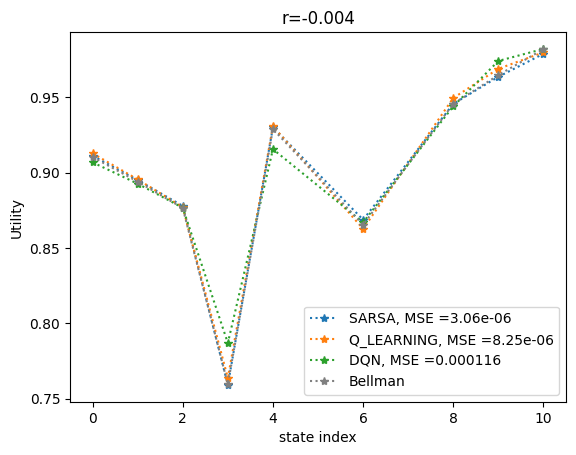

In [55]:
plt.figure()
MSE_SARSA = 0.0
MSE_Q_LEARNING = 0.0
MSE_DEEP =0.0

for i in range(len(U_final_CORRECT)):
  MSE_SARSA += (plot_U_SARSA_CORRECT[i] - U_final_CORRECT[i])**2 /len(U_final_CORRECT)
  MSE_Q_LEARNING += (plot_U_Q_LEARNING_CORRECT[i] - U_final_CORRECT[i])**2/len(U_final_CORRECT)
  MSE_DEEP+= (plot_U_DEEP_CORRECT[i] - U_final_CORRECT[i])**2/len(U_final_CORRECT)

label_SARSA = "SARSA, MSE ="+f"{MSE_SARSA:.3g}"
label_Q_LEARNING ="Q_LEARNING, MSE ="+f"{MSE_Q_LEARNING:.3g}"
label_DQN =  "DQN, MSE ="+f"{MSE_DEEP:.3g}"
plt.plot(index_CORRECT,plot_U_SARSA_CORRECT, marker="*", linestyle =":", label=label_SARSA)
plt.plot(index_CORRECT,plot_U_Q_LEARNING_CORRECT, marker="*", linestyle =":", label=label_Q_LEARNING)
plt.plot(index_CORRECT,plot_U_DEEP_CORRECT, marker="*", linestyle =":", label=label_DQN)
plt.plot(index_CORRECT, U_final_CORRECT, marker="*",linestyle = ":",label="Bellman", color = "gray")
plt.xlabel("state index")
plt.ylabel("Utility")
plt.legend()
title = "r="+ f'{r:,}'
plt.title(title)

plt.savefig("Utility_DQN.pdf")

## Plot 2: Utility + residuals ##

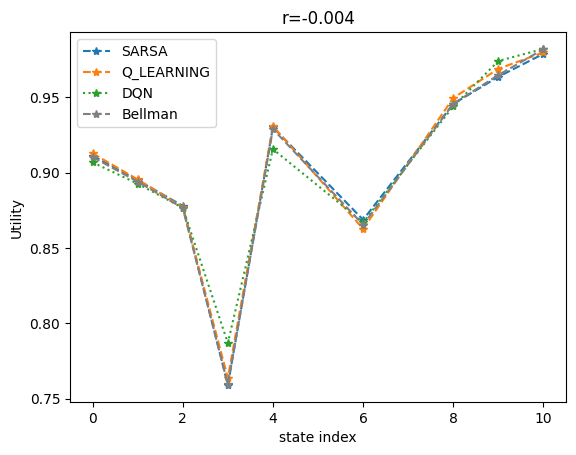

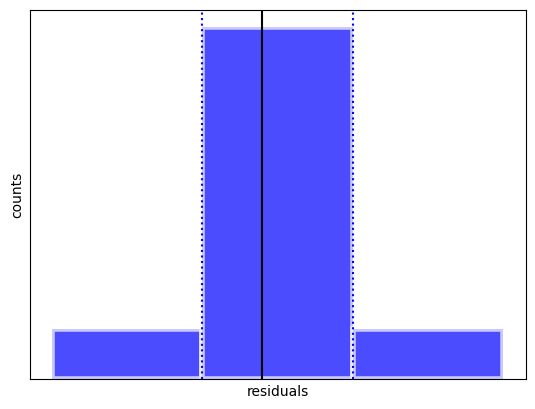

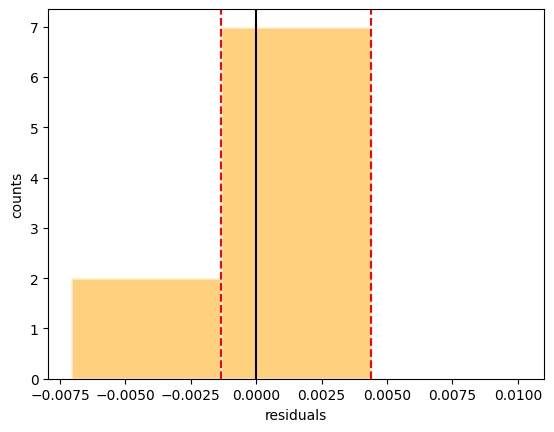

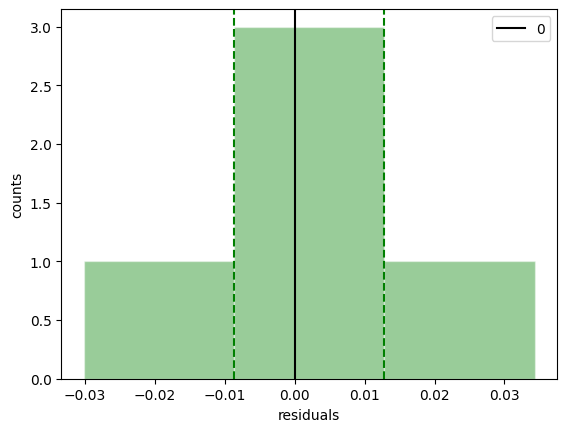

In [56]:
fig, ax1 = plt.subplots()
ax1.plot(index_CORRECT, plot_U_SARSA_CORRECT, marker="*", linestyle="--", label="SARSA")
ax1.plot(index_CORRECT, plot_U_Q_LEARNING_CORRECT, marker="*", linestyle="--", label="Q_LEARNING")
plt.plot(index_CORRECT,plot_U_DEEP_CORRECT, marker="*", linestyle =":", label="DQN")
ax1.plot(index_CORRECT, U_final_CORRECT, marker="*", linestyle="--", label="Bellman",color = "gray")
ax1.set_xlabel("state index")
ax1.set_ylabel("Utility")
ax1.legend()

plt.title(title)

'''
# Creazione della seconda figura come un inset
ax_inset = inset_axes(ax1, width="30%", height="30%", loc='lower right', bbox_to_anchor=(6, 0.1, 10, 0.1))  # posizionamento dell'inset
ax_inset.hist(residuals, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=1, color="black")
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="red", label="std")
ax_inset.axvline(avg_SARSA-std_SARSA, color="red")
ax_inset.set_yticks([])
ax_inset.legend()
'''
# Creazione della seconda figura come un inset manuale
# Gli argomenti sono: [left, bottom, width, height] in percentuale della figura principale
#ax_inset = fig.add_axes([0.6, 0.2, 0.3, 0.3])
fig,ax_inset=plt.subplots()
ax_inset.hist(residuals_SARSA, bins=[avg_SARSA-3*std_SARSA, avg_SARSA-std_SARSA, avg_SARSA+std_SARSA, avg_SARSA+3*std_SARSA], edgecolor='white', linewidth=4, color="blue", alpha = 0.7)
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(avg_SARSA+std_SARSA, color="blue", linestyle = ":")
ax_inset.axvline(avg_SARSA-std_SARSA, color="blue", linestyle = ":")
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.axvline(0, color="black", label="0")
fig,ax_inset=plt.subplots()

ax_inset.hist(residuals_Q_LEARNING, bins=[avg_Q_LEARNING-3*std_Q_LEARNING, avg_Q_LEARNING-std_Q_LEARNING, avg_Q_LEARNING+std_Q_LEARNING, avg_Q_LEARNING+3*std_Q_LEARNING], edgecolor='white', linewidth=2, color="orange",alpha =0.5)
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(0, color="black", label="0")
ax_inset.axvline(avg_Q_LEARNING+std_Q_LEARNING, color="red",  linestyle = "--")
ax_inset.axvline(avg_Q_LEARNING-std_Q_LEARNING, color="red", linestyle = "--")
fig,ax_inset=plt.subplots()

ax_inset.hist(residuals_DEEP, bins=[avg_DEEP-3*std_DEEP, avg_DEEP-std_DEEP, avg_DEEP+std_DEEP, avg_DEEP+3*std_DEEP], edgecolor='white', linewidth=1, color="green",alpha =0.4)
ax_inset.set_xlabel("residuals")
ax_inset.set_ylabel("counts")
ax_inset.axvline(0, color="black", label="0")
ax_inset.axvline(avg_DEEP+std_DEEP, color="green",  linestyle = "--")
ax_inset.axvline(avg_DEEP-std_DEEP, color="green", linestyle = "--")

ax_inset.legend()
fig.savefig("Utility.pdf")

## Plot of the policies ##

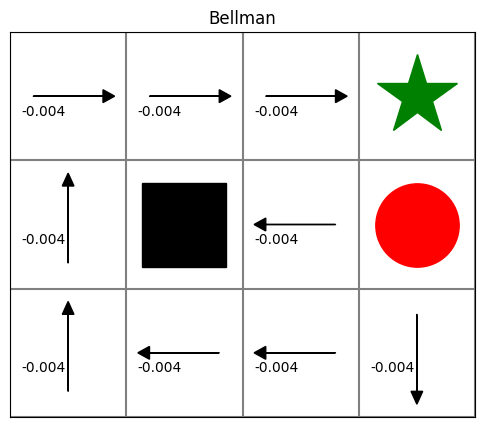

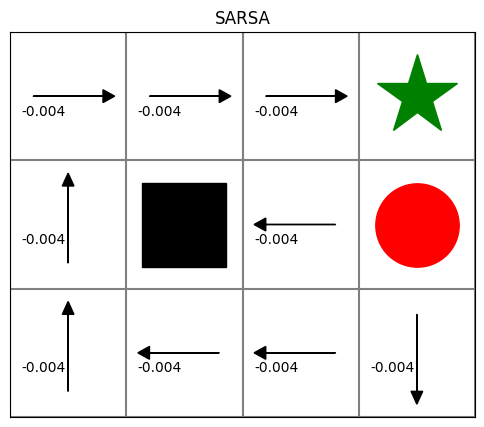

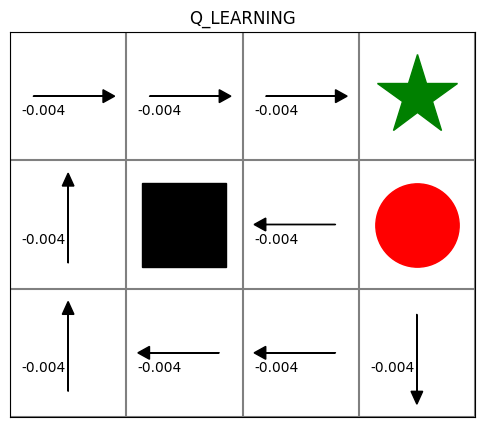

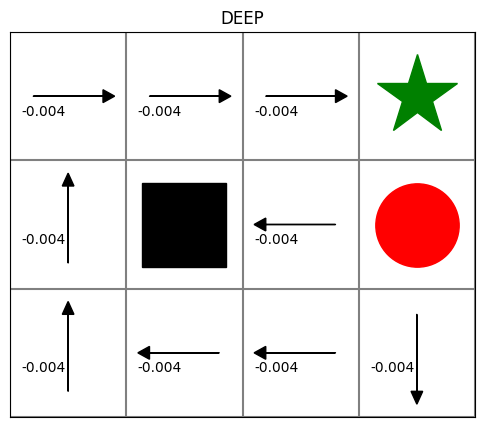

In [57]:

my_title = "Bellman"
plot_policy(policy, title = my_title)
my_title = "SARSA"
plot_policy(policy_SARSA, title = my_title)
my_title = "Q_LEARNING"
plot_policy(policy_Q_LEARNING, title = my_title)
my_title = "DEEP"
plot_policy(policy_DEEP, title = my_title)